## Entrainement de nos modèles sur la base RAVDESS

In [41]:
#!pip install seaborn
#!pip install audiomentations
#!pip install librosa
#!pip install fastparquet

In [1]:
import os
import re
import joblib
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from audiomentations import Compose, TimeStretch, PitchShift, AddGaussianNoise
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

### Les dossiers des audios d'entrainement des modèles et des tests finaux

In [2]:
audio_directory = "data/audio_speech_emotion"
test_directory = "data/audio_test_data"

### Définition des fonctions utiles

In [3]:
# Fonction de precession du fichier en vue de le normaliser
def process_audio(file_path):
    y, sr = librosa.load(file_path)
    y, _ = librosa.effects.trim(y)

    normalized_y = librosa.util.normalize(y)

    return normalized_y, sr

In [4]:
def extract_features(data, sample_rate):

    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    rms_energy = np.mean((librosa.feature.rms(y=data)).T, axis=0)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    spectral_spread = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
    spectral_flux = np.mean(librosa.onset.onset_strength(y=data, sr=sample_rate).T, axis=0)
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=data, sr=sample_rate).T, axis=0)

    # Stack all features horizontally
    return zcr, rms_energy, spectral_centroid, spectral_spread, spectral_flux, mfcc, chroma


In [5]:
# Fonction d'augmentation des fichiers audios
def augment_audio(y, sr):
    augment = Compose([
        TimeStretch(min_rate=0.8, max_rate=1.2),
        PitchShift(min_semitones=-2, max_semitones=2),
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015)
    ])

    augmented_y = augment(samples=y, sample_rate=sr)

    return augmented_y

In [6]:
# Dans notre contexte, nous avons décidé de nous concentrer sur la prédiction d'une émotion: la colère
def is_anger(emotion):
    return 1 if emotion == "anger" else 0

In [141]:
audio_files = []
emotions = []

zcr_list = []
rms_energy_list = []
spectral_centroid_list = []
spectral_spread_list = []
spectral_flux_list = []
mfcc_list = []
chroma_list = []

emotion_mapping = {
    'ang': 'anger',
    'cal': 'calm',
    'dis': 'disgust',
    'fea': 'fear',
    'hap': 'happiness',
    'neu': 'neutral',
    'sad': 'sadness',
    'sur': 'surprise'
}

In [142]:
for filename in tqdm(os.listdir(audio_directory)):
    if filename.endswith(".wav"):
        match = re.search(r'^([a-zA-Z]{3})', filename)
        emotion = emotion_mapping.get(match.group(1), 'unknown')

        file_path = os.path.join(audio_directory, filename)

        # Extration des features des audios de base
        normalized_y, sr = process_audio(file_path)
        original_zcr, original_rms_energy, original_spectral_centroid, original_spectral_spread, original_spectral_flux, original_mfcc, original_chroma = extract_features(normalized_y, sr)

        # Extraction des features des audios augmentés
        augmented_y = augment_audio(normalized_y, sr)
        augmented_zcr, augmented_rms_energy, augmented_spectral_centroid, augmented_spectral_spread, augmented_spectral_flux, augmented_mfcc, augmented_chroma = extract_features(augmented_y, sr)

        audio_files.extend([filename, f"augmented_{filename}"])
        emotions.extend([emotion, emotion])
        
        zcr_list.extend([original_zcr, augmented_zcr])
        rms_energy_list.extend([original_rms_energy, augmented_rms_energy])
        spectral_centroid_list.extend([original_spectral_centroid, augmented_spectral_centroid])
        spectral_spread_list.extend([original_spectral_spread, augmented_spectral_spread])
        spectral_flux_list.extend([original_spectral_flux, augmented_spectral_flux])
        mfcc_list.extend([original_mfcc, augmented_mfcc])
        chroma_list.extend([original_chroma, augmented_chroma])

100%|██████████| 1260/1260 [03:45<00:00,  5.59it/s]


In [143]:
# Création d'un dataFrame aavec les features extrait
df = pd.DataFrame({
    'Audio_File': audio_files,
    'Emotion': emotions,
    'ZCR': zcr_list,
    'RMS_Energy': rms_energy_list,
    'Spectral_Centroid': spectral_centroid_list,
    'Spectral_Spread': spectral_spread_list,
    'Spectral_Flux': spectral_flux_list,
    'MFCC': mfcc_list,
    'Chroma': chroma_list
})

In [144]:
df.head()

,Audio_File,Emotion,ZCR,RMS_Energy,Spectral_Centroid,Spectral_Spread,Spectral_Flux,MFCC,Chroma
0,hap_N_kids_rep2_M5.wav,happiness,[0.2652074841485507],[0.04497045],[2888.144626167434],[2659.0777218255103],1.337445,"[-391.43936, 63.173878, -0.6071635, 14.485641,...","[0.48389363, 0.5317753, 0.57651436, 0.6554642,..."
1,augmented_hap_N_kids_rep2_M5.wav,happiness,[0.3172271286231884],[0.031573374],[4190.885241021996],[2976.3761439211057],1.147218,"[-279.1983, 34.352123, 1.4375763, 7.2813077, 3...","[0.5722919, 0.6059828, 0.63265544, 0.6746848, ..."
2,fea_N_kids_rep2_M11.wav,fear,[0.1872378355704698],[0.06619437],[2758.465001543908],[2910.6703779334357],1.305585,"[-357.1314, 56.038853, 16.790045, 11.479772, 4...","[0.5169971, 0.4885916, 0.47065854, 0.53103983,..."
3,augmented_fea_N_kids_rep2_M11.wav,fear,[0.33303402894295303],[0.052809983],[4505.043316850528],[3188.9897035703666],1.061594,"[-175.80244, 23.96672, 9.98257, 3.7132938, -1....","[0.604354, 0.6363266, 0.6495164, 0.6839648, 0...."
4,hap_S_kids_rep1_M3.wav,happiness,[0.1615547839506173],[0.066307835],[2781.8333782626682],[2493.3519021333145],1.923744,"[-311.20053, 53.441936, -11.738406, -4.947586,...","[0.44442034, 0.5124865, 0.44424504, 0.42747003..."


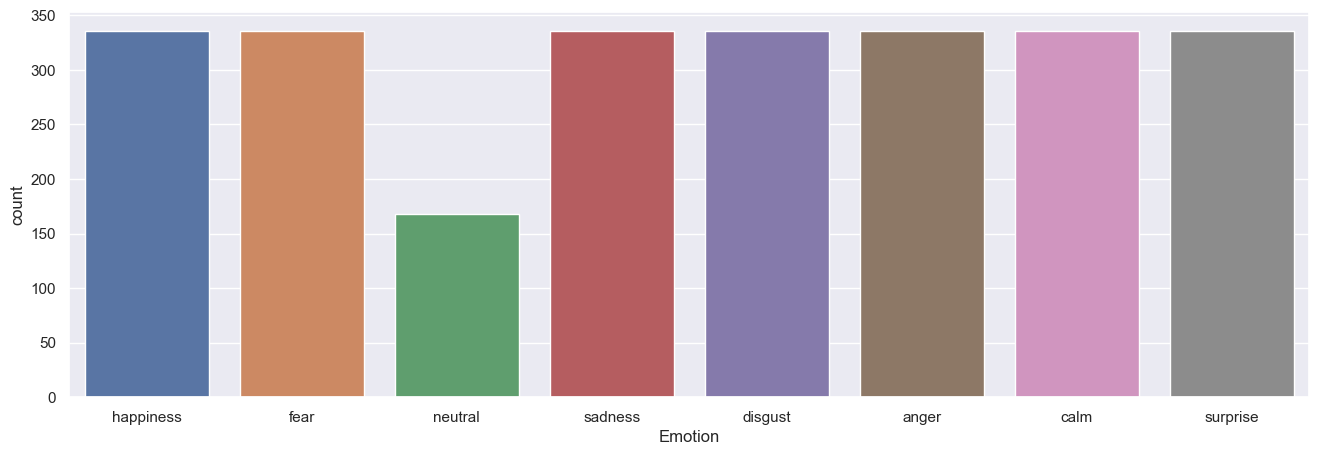

In [145]:
# Voyons la répartition de chaque émotion
sns.countplot(df, x="Emotion", hue="Emotion")
sns.set(rc={'figure.figsize':(16,5)})

In [146]:
df["anger"] = df['Emotion'].apply(is_anger)

In [147]:
# Convert types
df["ZCR"] = df["ZCR"].astype(float)
df["RMS_Energy"] = df["RMS_Energy"].astype(float)
df["Spectral_Centroid"] = df["Spectral_Centroid"].astype(float)
df["Spectral_Spread"] = df["Spectral_Spread"].astype(float)

In [148]:
# Dataframe de chaque categories de features de MFCC et CHROMA
mfccs_list_columns = [f'mfcc_{i}' for i in range(len(mfcc_list[0]))]
df_mfccs = pd.DataFrame(mfcc_list, columns=mfccs_list_columns)

chroma_list_columns = [f'chroma_{i}' for i in range(len(chroma_list[0]))]
df_chroma = pd.DataFrame(chroma_list, columns=chroma_list_columns)

In [149]:
# Dataset d'exploitation avec features et sans features selection
features = pd.concat([df.drop(["MFCC", "Chroma", "anger"], axis=1), df_mfccs, df_chroma, df["anger"]], axis=1)
features = features.sample(frac = 1) # A changer si le dataset est trop grand
features.head()

,Audio_File,Emotion,ZCR,RMS_Energy,Spectral_Centroid,Spectral_Spread,Spectral_Flux,mfcc_0,mfcc_1,mfcc_2,...,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,anger
1073,augmented_cal_N_kids_rep1_M9.wav,calm,0.160170,0.042752,2850.813089,2684.106229,1.028908,-366.435150,71.568932,13.069126,...,0.501313,0.502839,0.489042,0.447125,0.487394,0.493933,0.461280,0.479121,0.508697,0
559,augmented_dis_N_kids_rep1_M7.wav,disgust,0.297626,0.071246,4132.290718,3102.322825,1.334316,-160.254822,34.748951,11.272547,...,0.625197,0.607559,0.545584,0.533796,0.543534,0.575249,0.551741,0.571438,0.575848,0
2280,neu_N_kids_rep1_F10.wav,neutral,0.121019,0.083242,2683.695367,2744.974631,1.237098,-358.364349,52.088406,0.474366,...,0.375655,0.448332,0.467367,0.467311,0.471363,0.462044,0.420986,0.442318,0.446002,0
484,dis_S_dogs_rep2_M3.wav,disgust,0.224664,0.056873,3103.648753,2463.404284,1.811451,-305.701111,50.141113,-11.495375,...,0.423112,0.450009,0.495988,0.466644,0.501811,0.493117,0.494896,0.539904,0.457205,0
1952,sur_S_dogs_rep1_M19.wav,surprise,0.162591,0.044606,2235.945531,2409.739409,1.637107,-395.149994,69.403870,5.779568,...,0.490438,0.517028,0.508966,0.450276,0.531131,0.556868,0.600019,0.609081,0.572538,0


In [150]:
features.shape

(2520, 33)

In [151]:
# Sauvegarde du dataset en parquet
features.to_parquet('data/datasets/features.parquet', index=False)

## Entrainement des models

In [7]:
# Chargelent du dataset
features = pd.read_parquet('data/datasets/features.parquet')

### Définition des modèles

In [37]:
def train_model_knn(X_train, y_train):
    model = KNeighborsClassifier()
    param_grid = {'n_neighbors': [1, 3, 5, 7, 9]}
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', return_train_score=True)
    history = grid_search.fit(X_train, y_train).cv_results_
    best_knn = grid_search.best_estimator_

    return best_knn, history

def train_model_svc(X_train, y_train):
    model = SVC()
    param_grid = {'C': [0.1, 1, 10, 100]}
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=make_scorer(accuracy_score), return_train_score=True)
    history = grid_search.fit(X_train, y_train).cv_results_
    best_svc = grid_search.best_estimator_

    return best_svc, history

def train_model_dt(X_train, y_train):
    model = DecisionTreeClassifier()
    param_grid = {'max_depth': [None, 5, 10, 15, 20]}
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', return_train_score=True)
    history = grid_search.fit(X_train, y_train).cv_results_
    best_decision_tree = grid_search.best_estimator_

    return best_decision_tree, history

In [9]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    _accuracy = accuracy_score(y_test, y_pred)
    _precision = precision_score(y_test, y_pred, average='weighted')
    _recall = recall_score(y_test, y_pred, average='weighted')
    _f1_score = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {_accuracy:.4f}")
    print(f"Precision: {_precision:.4f}")
    print(f"Recall: {_recall:.4f}")
    print(f"F1 Score: {_f1_score:.4f}")

### Séparation des données en données de train, test et validation

In [10]:
X = features.drop(columns=['Audio_File', 'Emotion', 'anger'])
y = features["anger"].values

# Normalisation des données
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.2, random_state=21)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.1, random_state=21)

In [11]:
X_train.shape, X_test.shape, X_valid.shape

((2016, 30), (453, 30), (51, 30))

In [12]:
def show_loss_accuracy(history, param_name):
    # Afficher les courbes d'évolution de la loss et de l'accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history[f'param_{param_name}'], history['mean_test_score'], label='Validation Accuracy')
    plt.plot(history[f'param_{param_name}'], history['mean_train_score'], label='Training Accuracy')
    plt.title(f'Accuracy vs Number of {param_name}')
    plt.xlabel(f'Number of {param_name}')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history[f'param_{param_name}'], history['std_test_score'], label='Validation Std')
    plt.plot(history[f'param_{param_name}'], history['std_train_score'], label='Training Std')
    plt.title(f'Standard Deviation of Accuracy vs Number of {param_name}')
    plt.xlabel(f'Number of {param_name}')
    plt.ylabel('Standard Deviation')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Entrainement des modèles

Accuracy: 0.8609
Precision: 0.8526
Recall: 0.8609
F1 Score: 0.8063


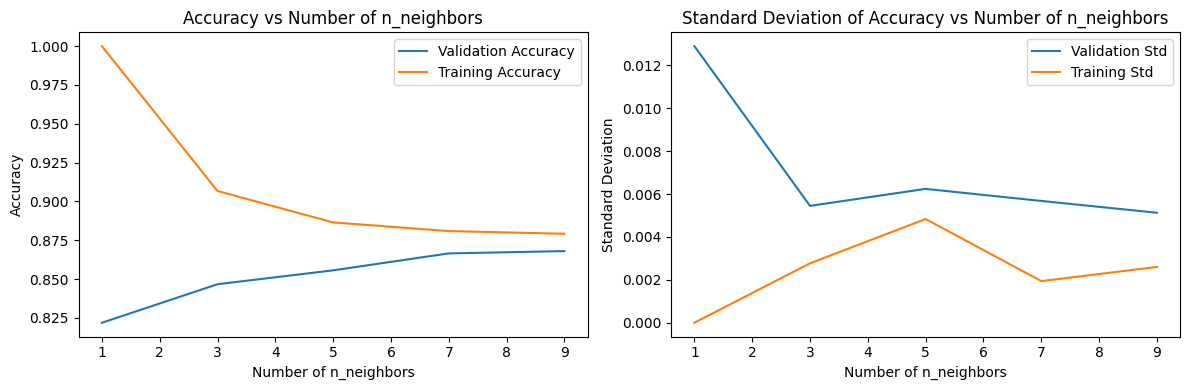

In [42]:
knn_model, history = train_model_knn(X_train, y_train)
evaluate_model(knn_model, X_test, y_test)
show_loss_accuracy(history, 'n_neighbors')

/Users/anisoft/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.8543
Precision: 0.7298
Recall: 0.8543
F1 Score: 0.7872


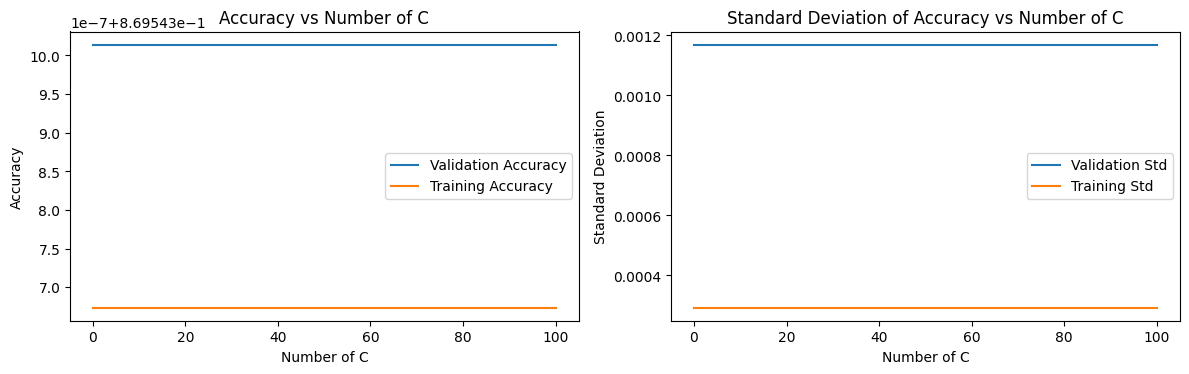

In [43]:
svm_model, history = train_model_svc(X_train, y_train)
evaluate_model(svm_model, X_test, y_test)
show_loss_accuracy(history, 'C')

Accuracy: 0.8764
Precision: 0.8599
Recall: 0.8764
F1 Score: 0.8507


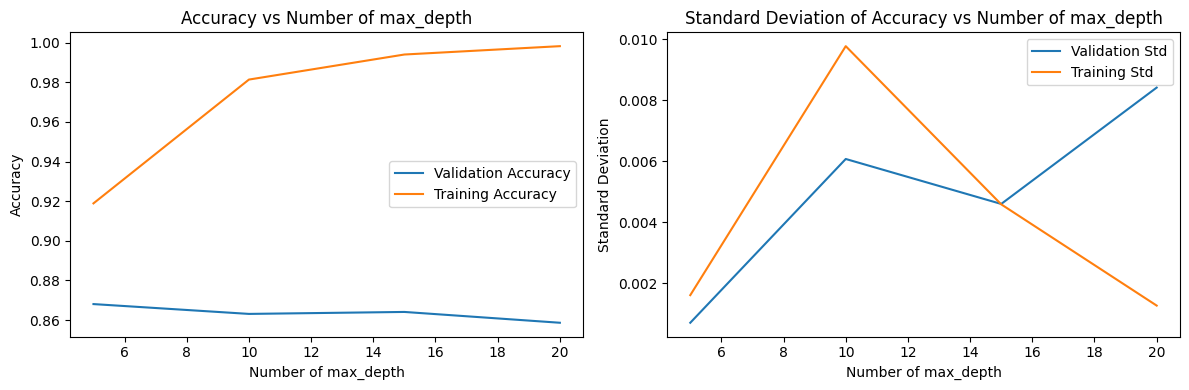

In [44]:
dtc_model, history = train_model_dt(X_train, y_train)
evaluate_model(dtc_model, X_test, y_test)
show_loss_accuracy(history, 'max_depth')

In [18]:
t = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# Sauvegarde des modeles
print("🔄 Models saving ...")
joblib.dump(knn_model, f'models/knn_model_{t}.pkl')
joblib.dump(svm_model, f'models/svm_model_{t}.pkl')
joblib.dump(dtc_model, f'models/dtc_model_{t}.pkl')
print("✅ Models saved successfully !")

🔄 Models saving ...
✅ Models saved successfully !


## Validation des modèles

In [19]:
predictions = knn_model.predict(X_valid)

In [20]:
y_valid

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0])

In [21]:
compare = pd.DataFrame({'Actual': y_valid, 'Predicted': predictions, 'OK ?': y_valid == predictions})
compare.head(20)

,Actual,Predicted,OK ?
0,0,0,True
1,0,0,True
2,0,0,True
3,0,0,True
4,1,0,False
5,0,0,True
6,0,0,True
7,0,0,True
8,0,0,True
9,0,0,True


## Test des modèles sur d'autres fichiers audios

In [242]:
# Chargement des modeles
#knn_model = joblib.load('models/knn_model.pkl')
#svm_model = joblib.load('models/svm_model.pkl')
#dtc_model = joblib.load('models/dtc_model.pkl')

In [22]:
def predict_emotion(audio_test_file):
    
    normalized_y, sr = process_audio(audio_test_file)
    flat_zcr, flat_rms_energy, flat_spectral_centroid, flat_spectral_spread, flat_spectral_flux, flat_mfcc, flat_chroma = extract_features(normalized_y, sr)

    flat_features = np.hstack((flat_zcr, flat_rms_energy, flat_spectral_centroid, flat_spectral_spread, flat_spectral_flux, flat_mfcc, flat_chroma))
    flat_features = np.array(flat_features).reshape(1, -1)

    knn_prediction = knn_model.predict(flat_features)
    svm_prediction = svm_model.predict(flat_features)
    dtc_prediction = dtc_model.predict(flat_features)

    print("Audio File is anger: ", audio_test_file)
    print("KNN: ", knn_prediction == 1)
    print("SVM: ", svm_prediction == 1)
    print("DTC: ", dtc_prediction == 1)

In [23]:
def get_true_label(file_path):
    return os.path.basename(file_path).split(".")[0].startswith("a")

In [24]:
def predict_emotions_in_directory(model, directory_path):
    audio_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.wav')]
        
    predictions = []
    true_emotions = []

    correct_predictions = 0
    incorrect_predictions = 0
    total_angry_audio = 0

    for audio_file in tqdm(audio_files):
        
        # without augmentation
        normalized_y, sr = process_audio(audio_file)
        flat_zcr, flat_rms_energy, flat_spectral_centroid, flat_spectral_spread, flat_spectral_flux, flat_mfcc, flat_chroma = extract_features(normalized_y, sr)

        flat_features = np.hstack((flat_zcr, flat_rms_energy, flat_spectral_centroid, flat_spectral_spread, flat_spectral_flux, flat_mfcc, flat_chroma))
        flat_features = np.array(flat_features).reshape(1, -1)
            
        # Make prediction using the provided model
        prediction = model.predict(flat_features)

        # Check if the prediction is correct
        true_label = get_true_label(audio_file)
        total_angry_audio += 1 if true_label else 0

        if prediction and true_label:
            correct_predictions += 1
        else:
            incorrect_predictions += 1

        predictions.append(prediction)
        true_emotions.append(true_label)

    total_predictions = len(audio_files)
    print(f"\nModel: {model}")
    print(f"Total Predictions: {total_predictions}")
    print(f"Correct Predictions: {correct_predictions}/{total_angry_audio} angry files")
    print(f"Incorrect Predictions: {incorrect_predictions}")
        
    return audio_files, predictions, true_emotions

In [33]:
audio_files, predicted_probabilities, true_emotions = predict_emotions_in_directory(knn_model, test_directory)

  0%|          | 0/120 [00:00<?, ?it/s]/Users/anisoft/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
  1%|          | 1/120 [00:00<00:12,  9.71it/s]/Users/anisoft/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
  2%|▏         | 2/120 [00:00<00:19,  6.14it/s]/Users/anisoft/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
  2%|▎         | 3/120 [00:00<00:22,  5.21it/s]/Users/anisoft/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature


Model: KNeighborsClassifier(n_neighbors=11)
Total Predictions: 120
Correct Predictions: 1/16 angry files
Incorrect Predictions: 119


In [26]:
audio_files, predicted_probabilities, true_emotions = predict_emotions_in_directory(svm_model, test_directory)

  0%|          | 0/120 [00:00<?, ?it/s]

/Users/anisoft/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
  1%|          | 1/120 [00:00<00:19,  5.96it/s]/Users/anisoft/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
  2%|▏         | 2/120 [00:00<00:26,  4.53it/s]/Users/anisoft/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
  2%|▎         | 3/120 [00:00<00:20,  5.73it/s]/Users/anisoft/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/anisoft/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/base.py


Model: SVC(C=0.1)
Total Predictions: 120
Correct Predictions: 0/16 angry files
Incorrect Predictions: 120


In [39]:
audio_files, predicted_probabilities, true_emotions = predict_emotions_in_directory(dtc_model, test_directory)

  0%|          | 0/120 [00:00<?, ?it/s]/Users/anisoft/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/anisoft/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
  2%|▏         | 2/120 [00:00<00:09, 12.43it/s]/Users/anisoft/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/anisoft/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
  3%|▎         | 4/120 [00:00<00:14,  8.10it/s]/Users/anisoft/


Model: DecisionTreeClassifier(max_depth=5)
Total Predictions: 120
Correct Predictions: 8/16 angry files
Incorrect Predictions: 112
